In [14]:
import numpy as np
import pandas as pd
import yaml
import torch
import scanpy as sc
import scvi
import scib 
from scarches.models.scpoli import scPoli

from scib_metrics.benchmark import Benchmarker

from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics

from celldreamer.paths import DATA_DIR

from celldreamer.models.fm.ode import torch_wrapper
from tqdm import tqdm 
from pathlib import Path

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

In [15]:
adata = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'c_elegans' / 'c_elegans.h5ad')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


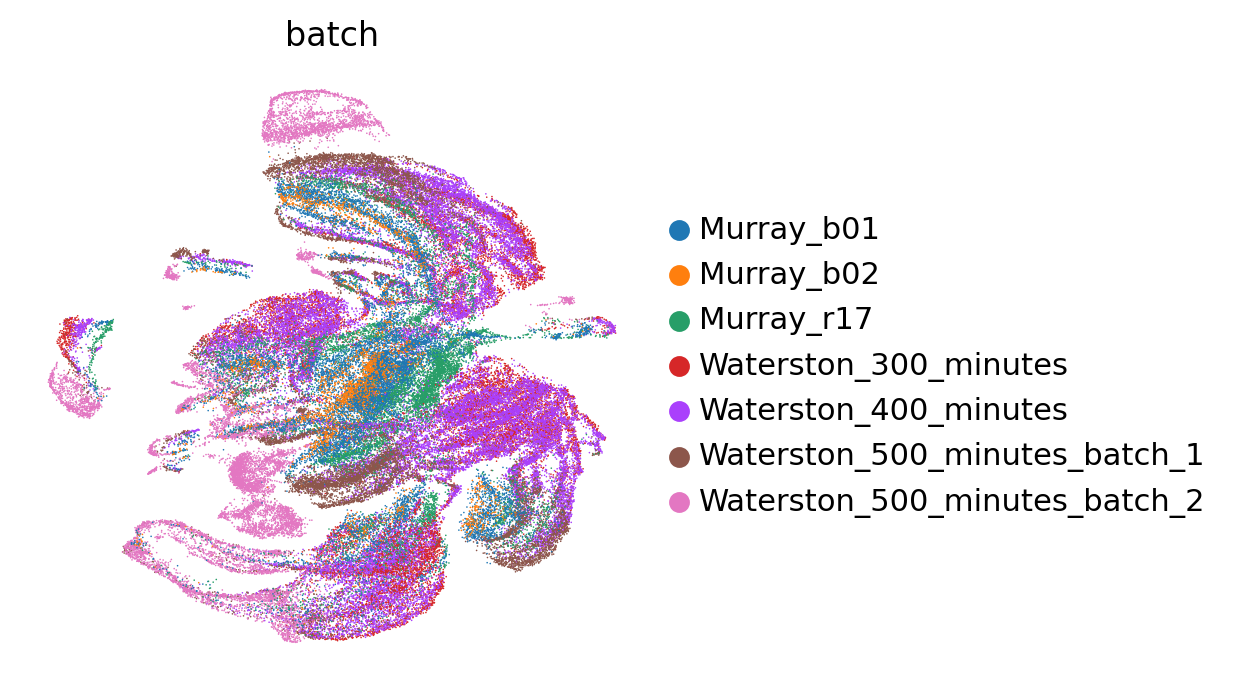

In [16]:
sc.pl.umap(adata, color="batch")

In [17]:
adata

AnnData object with n_obs × n_vars = 89701 × 17747
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

# scVI

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer="X_counts", batch_key="batch")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [7]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")

In [7]:
model.train(max_epochs=100)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, y

Epoch 100/100: 100%|██████████| 100/100 [2:16:05<00:00, 80.25s/it, v_num=1, train_loss_step=2.94e+3, train_loss_epoch=2.87e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [2:16:05<00:00, 81.66s/it, v_num=1, train_loss_step=2.94e+3, train_loss_epoch=2.87e+3]


In [8]:
# model = scvi.model.SCVI.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_model_neurips/",
#                              adata)

In [9]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [11]:
model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_model_celegans")

In [ ]:
# sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)

In [ ]:
# sc.tl.umap(adata)

In [ ]:
# sc.pl.umap(adata, color="batch")

In [ ]:
# sc.pl.umap(adata, color="cell_type")

# scanVI

In [8]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown"
)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/model/_scanvi.py:200: UserWarning: Passed in scvi model hasn't been trained yet.
  scvi_model._check_if_trained(message="Passed in scvi model hasn't been trained yet.")
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [9]:
scanvi_model.train(max_epochs=100, batch_size=256, early_stopping=True)

INFO     Training for 100 epochs.                                                                                  


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, y

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# scanvi_model = scvi.model.SCANVI.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_model_neurips",
#                              adata)

In [11]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)


KeyboardInterrupt



In [ ]:
scanvi_model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_model_celegans")

In [ ]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color="batch")

In [ ]:
sc.pl.umap(adata, color="cell_type")

# scPoli

In [1]:
scpoli_model

NameError: name 'scpoli_model' is not defined

In [2]:
adata.layers["X_norm"] = adata.X.copy()
adata.X = adata.layers["X_counts"].copy()

scpoli_model = scPoli(adata=adata,
                        condition_keys="batch",
                        cell_type_keys="cell_type",
                        embedding_dims=10,
                        latent_dim=50,
                        recon_loss='nb',
                    )
scpoli_model.train(
    n_epochs=100,
    pretraining_epochs=40
)

NameError: name 'adata' is not defined

In [ ]:
# scpoli_model.model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scpoli_model_neurips/model_params.pt"))

In [ ]:
# scpoli_model.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scpoli_model_neurips/", 
#                    )

In [22]:
#get latent representation of reference data
scpoli_model.model.eval()
data_latent = scpoli_model.get_latent(
    adata,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata.obs.copy()
sc.pp.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  c = torch.tensor(label_tensor, device=device).T
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/func

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


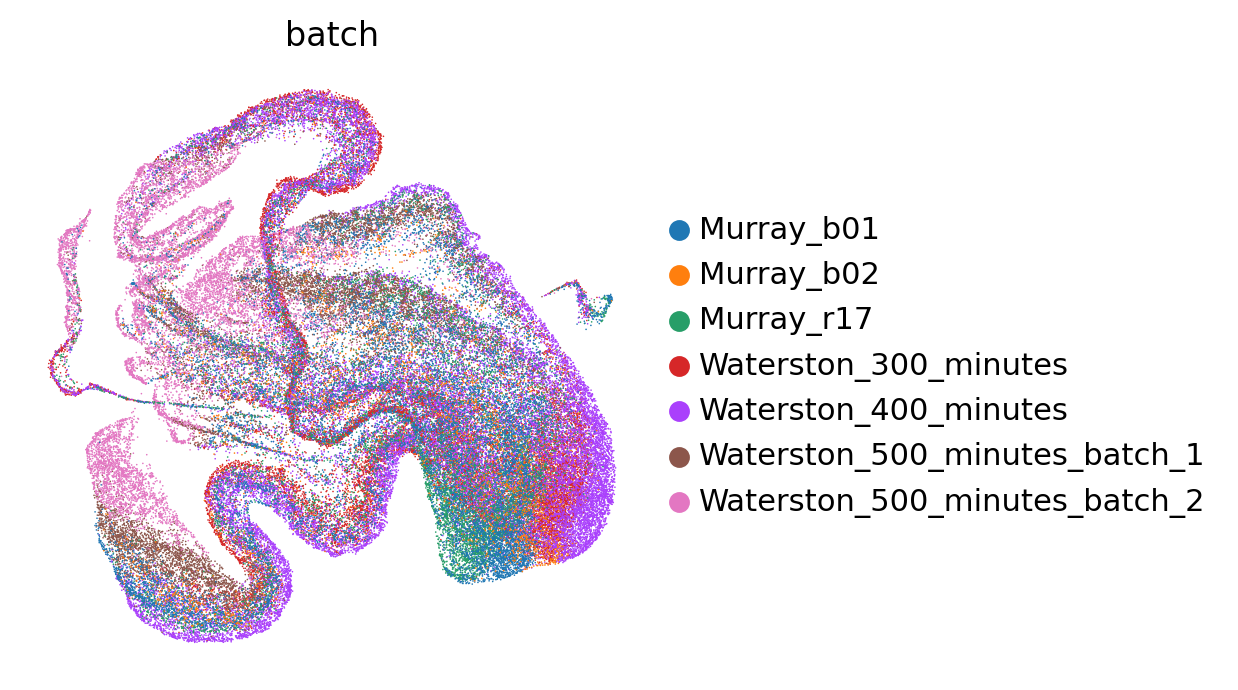

In [23]:
sc.pl.umap(adata_latent, color="batch")

In [ ]:
adata.obsm["X_scpoli"] = data_latent

In [ ]:
scpoli_model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scpoli_model_celegans")

# Read cellFlow corrected dataset

In [ ]:
adata_corrected_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/c_elegans_batch_correction/adata_corrected.h5ad")

In [ ]:
# adata_corrected_decoded_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/celegans_batch_correction/adata_corrected_decoded.h5ad")

In [ ]:
sc.pl.umap(adata_corrected_cellflow, color="batch")

In [ ]:
sc.pl.umap(adata_corrected_cellflow, color="batch")

In [ ]:
adata.obsm["X_cellFlow"] = adata_corrected_cellflow.X.copy()

# Compute metrics

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY, "X_scpoli", "X_cellFlow"],
    n_jobs=-1,
)
bm.benchmark()

In [ ]:
# import pickle as pkl 

# with open("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration.pkl", "wb") as file:
#     pkl.dump(bm, file)

# with open("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration.pkl", "rb") as file:
#     bm = pkl.load(file)

In [ ]:
bm._results.columns = ['Uncorrected', 'scVI', 'scANVI', "scPoli", 'cellFlow', 'Metric Type']

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
# df = bm.get_results(min_max_scale=False)
# df.to_csv("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration.csv")

In [ ]:
df = bm.get_results(min_max_scale=False)

In [ ]:
df

In [ ]:
df.T.groupby("Metric Type").mean()

In [ ]:
df.T.groupby("Metric Type").std()/np.sqrt(5)